In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer, make_column_selector
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('data/Nostupidquestions_davinci.csv')

In [3]:
teststring = 'lol momlol lollol'

Things to look for
semicolons, sentences without periods, abbreviations,

result of looking through the data. 
abbreviations and 
sentances without periods are human only things
semicolons are used by both human and AI, so I'm going to look for responses without periods, make that a column, and response with abbreviations and make that a column.

In [4]:
abbreviations = ['lol', 'imo', 'tbh', 'pov', 'bf', 'gf', 'irl', 'tmi', 'fyi', 'imo', 'nvm', 'gl', 'fwiw', 'idc', 'lmao', 'plz', 'wfh', 'idk']
abbreviations += [x.upper() for x in abbreviations]
abbreviations 
abbreviations

['lol',
 'imo',
 'tbh',
 'pov',
 'bf',
 'gf',
 'irl',
 'tmi',
 'fyi',
 'imo',
 'nvm',
 'gl',
 'fwiw',
 'idc',
 'lmao',
 'plz',
 'wfh',
 'idk',
 'LOL',
 'IMO',
 'TBH',
 'POV',
 'BF',
 'GF',
 'IRL',
 'TMI',
 'FYI',
 'IMO',
 'NVM',
 'GL',
 'FWIW',
 'IDC',
 'LMAO',
 'PLZ',
 'WFH',
 'IDK']

In [5]:
for x in abbreviations:
    regex = fr'\b{x}\b'
    print(regex)
    print(re.findall(regex,teststring))

\blol\b
['lol']
\bimo\b
[]
\btbh\b
[]
\bpov\b
[]
\bbf\b
[]
\bgf\b
[]
\birl\b
[]
\btmi\b
[]
\bfyi\b
[]
\bimo\b
[]
\bnvm\b
[]
\bgl\b
[]
\bfwiw\b
[]
\bidc\b
[]
\blmao\b
[]
\bplz\b
[]
\bwfh\b
[]
\bidk\b
[]
\bLOL\b
[]
\bIMO\b
[]
\bTBH\b
[]
\bPOV\b
[]
\bBF\b
[]
\bGF\b
[]
\bIRL\b
[]
\bTMI\b
[]
\bFYI\b
[]
\bIMO\b
[]
\bNVM\b
[]
\bGL\b
[]
\bFWIW\b
[]
\bIDC\b
[]
\bLMAO\b
[]
\bPLZ\b
[]
\bWFH\b
[]
\bIDK\b
[]


In [6]:
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
abbreviationslist = []
for str in df['answers']:
    for x in abbreviations:
        if x not in str:
            continue
        else:
            abbreviationslist.append(str)
len(abbreviationslist)

76

In [8]:
abbreviationslist = []
for str in df['da_vinci']:
    for x in abbreviations:
        if x not in str:
            continue
        else:
            abbreviationslist.append(str)
len(abbreviationslist)

110

In [9]:
df.head()

,titles,answers,da_vinci
0,"If Germany calls itself Deutschland, why don't...",It’s called “*exonyms*”.\n\nGermany is a trick...,\n\nIt is a matter of familiarity. For most pe...
1,Why do all girls seem to find other girls attr...,noticing beauty is different than having sexua...,\n\nThis is likely because people are generall...
2,Is it reasonable to not want to marry someone ...,"Hi /u/throwaway29383p,\n\nWe noticed you are a...","\n\nYes, it is reasonable to not want to marry..."
3,what’s the most offensive thing you’ve ever se...,This isn't super offensive like some suggestio...,\n\nThe most offensive thing I have ever seen ...
4,If WWIII kicks off would nuclear missiles be s...,ICBMs fly into space. No pilot is going to sh...,"\n\nIt is possible that, given enough time, nu..."


In [10]:
combined = [x for x in df['answers']]+ [x for x in df['da_vinci']] #stacking the df
ai_no = [0 for x in df['answers']] + [1 for x in df['da_vinci']]
newframe = pd.DataFrame({'text' : combined,"target" : ai_no})



In [11]:
newframe.to_csv('data/nostupidconcat.csv')

In [12]:
newframe

,text,target
0,It’s called “*exonyms*”.\n\nGermany is a trick...,0
1,noticing beauty is different than having sexua...,0
2,"Hi /u/throwaway29383p,\n\nWe noticed you are a...",0
3,This isn't super offensive like some suggestio...,0
4,ICBMs fly into space. No pilot is going to sh...,0
...,...,...
1807,in Advertisements\n\nBusinesses have a respon...,1
1808,"\n\nNo, it is generally not appropriate to con...",1
1809,"\n\nYes, it would be strange to only ask out p...",1
1810,"?\n\nWhen drug dealers get charges withdrawn, ...",1


After we stack the resposnes into 1 column I drop some username responses and get a new baseline

In [13]:
droppedu = newframe[newframe['text'].str.contains('/u/') == False] #dropping answers with /u/ an in app response to a user

In [14]:
droppedu['text'].str.contains('language model').value_counts()

text
False    1765
True        1
Name: count, dtype: int64

In [15]:
droppedu[(droppedu['text'].str.contains('language model') == True)] # the only value with language model referenced is about the hollywood strike and is human written/

,text,target
430,Studios are trying to get writers and actors t...,0


In [16]:
type(droppedu)
droppedu.shape

(1766, 2)

Looked at abbreviations, and no punctuaton conclusion is there's not enough data to use abbreviations only like 10 total abbreviations my regex could catch, and no puncutation has a lot but I couldn't figure out how to implement it.

In [17]:
droppedu['nopunctuation'] = [1 if x[-1] != '.' and x[-1] != '?' and x[-1] != '!' and x[-1] != '"' and x[-1] != " " else 0 for x in droppedu['text']]

C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\1944678130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['nopunctuation'] = [1 if x[-1] != '.' and x[-1] != '?' and x[-1] != '!' and x[-1] != '"' and x[-1] != " " else 0 for x in droppedu['text']]


In [18]:
for x in abbreviations: #allright did some regex total number of abbreviations i found was under 10 so I'm not going to look at it as a feature
    regex = fr'\b{x}\b'
    droppedu['abbreviations'] = droppedu['text'].apply(lambda x: re.findall(regex,x))
    print(droppedu['abbreviations'].value_counts())

abbreviations
[]            1762
[lol]            3
[lol, lol]       1
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]       1765
[tbh]       1
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]      1765
[bf]       1
Name: count, dtype: int64
abbreviations
[]      1765
[gf]       1
Name: count, dtype: int64


C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['abbreviations'] = droppedu['text'].apply(lambda x: re.findall(regex,x))
C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['abbreviations'] = droppedu['text'].apply(lambda x: re.findall(regex,x))
C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on

abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]      1765
[gl]       1
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]       1764
[idk]       2
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]       1764
[IMO]       2
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: count, dtype: int64
abbreviations
[]    1766
Name: co

C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['abbreviations'] = droppedu['text'].apply(lambda x: re.findall(regex,x))
C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['abbreviations'] = droppedu['text'].apply(lambda x: re.findall(regex,x))
C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\3660822905.py:3: SettingWithCopyWarning: 
A value is trying to be set on

In [19]:
droppedu['abbreviations'].value_counts() #trying to get these abbreviations but 

abbreviations
[]       1765
[IDK]       1
Name: count, dtype: int64

In [20]:
droppedu['nopunctuation'].value_counts()

nopunctuation
0    1553
1     213
Name: count, dtype: int64

In [21]:
droppedu.head()

,text,target,nopunctuation,abbreviations
0,It’s called “*exonyms*”.\n\nGermany is a trick...,0,0,[]
1,noticing beauty is different than having sexua...,0,1,[]
3,This isn't super offensive like some suggestio...,0,0,[]
4,ICBMs fly into space. No pilot is going to sh...,0,0,[]
5,You may need some clinical antiperspirant. Th...,0,0,[]


Baseline

In [22]:
droppedu['target'].value_counts(normalize=True) # this is the baseline score to beat almost exactly 50/50

target
1    0.513024
0    0.486976
Name: proportion, dtype: float64

More exploration of no punctuation

In [23]:
nopunc = droppedu[(droppedu['nopunctuation'] == 1)]

In [62]:
nopunc['target'].value_counts()

target
0    202
1     11
Name: count, dtype: int64

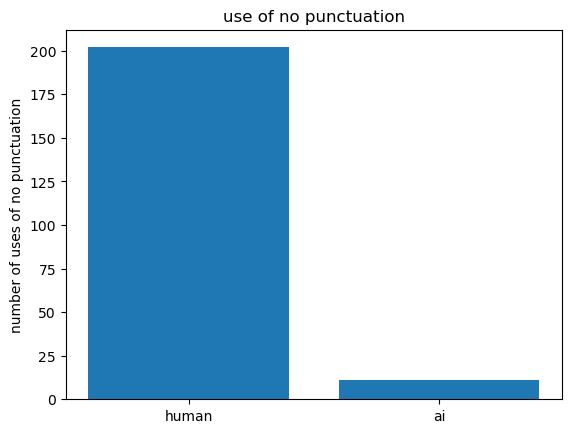

In [85]:
import matplotlib.pyplot as plt
plt.bar(['human', 'ai'], nopunc['target'].value_counts())
plt.title('use of no punctuation')
plt.ylabel('number of uses of no punctuation');

**Interpretation** Here we see that humans don't use punctuation to end their sentances way more than ai, normally ai will only not end with a punctuation when it provides something like a youtube link, or the end of a bullet pointed list.

In [25]:
check = nopunc[(nopunc['target'] == 1)]

In [26]:
for x in check['text']: #this is about as good as no punctuation is gonna get these are now youtube links and actual positive cases where chat gpt uses no punctuation
    print(x[-1])

”
e
g
s
g
e
n
r
s
r
a


In [73]:
wordlist = [len(x.split(' ')) for x in droppedu['text']]
droppedu['numwords'] = wordlist

C:\Users\ellio\AppData\Local\Temp\ipykernel_13752\722306587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  droppedu['numwords'] = wordlist


In [74]:
droppedu.head()

,text,target,nopunctuation,abbreviations,numwords
0,It’s called “*exonyms*”.\n\nGermany is a trick...,0,0,[],74
1,noticing beauty is different than having sexua...,0,1,[],8
3,This isn't super offensive like some suggestio...,0,0,[],79
4,ICBMs fly into space. No pilot is going to sh...,0,0,[],13
5,You may need some clinical antiperspirant. Th...,0,0,[],13


In [75]:
aiplot = droppedu[(droppedu['target'] == 1)]
humanplot = droppedu[(droppedu['target'] == 0)]

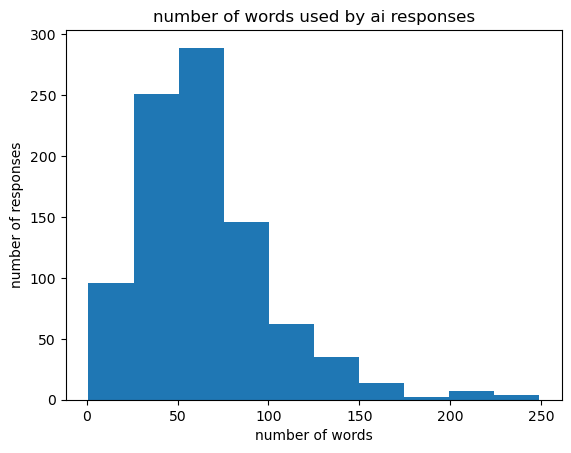

In [83]:
plt.hist(aiplot['numwords'])
plt.title('number of words used by ai responses')
plt.xlabel('number of words')
plt.ylabel('number of responses');

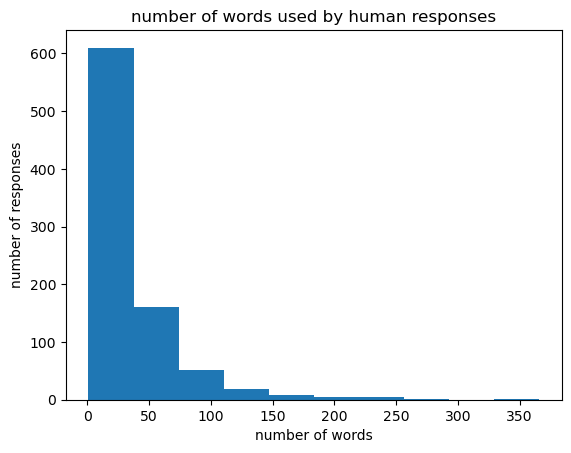

In [84]:
plt.hist(humanplot['numwords'])
plt.title('number of words used by human responses')
plt.xlabel('number of words')
plt.ylabel('number of responses');

**Interpretation** From the two charts above we can see ai varies it's responses more to fit the question, but humans use way less words way more often, probably becuase it takes humans way more time to type out words than it does an AI, and we have perception of that time we're losing. either way the number of words seems like a good indicator to catch AI.

Models

In [27]:
X = droppedu['text']
y = droppedu['target']
# for all models baseline is 50/50

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [29]:
# after discussing and thinking about it I couldn't get my column transformer to work, but adding my no punctuation column to the thousands
# of columns in count vectorizer wasn't the correct approach so it got scrapped.

#columnt = ColumnTransformer([ 

#    ('log', logpipe, make_column_selector(dtype_include = int)),
 
#('cvec', pipe, make_column_selector(dtype_include = object))
#])

In [30]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [31]:
from nltk.corpus import stopwords 
nlkt_stop = stopwords.words('english')
                            
pipe_params = {
'cvec__max_features' : [100,500, 1000, 2000, 3000],
'cvec__ngram_range' : [(1,1), (1,2)],
'cvec__stop_words' : ['english', None, nlkt_stop]
}

In [32]:
gs = GridSearchCV(pipe, pipe_params, cv = 5)

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_features': [100, 500, 1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [34]:
gs.score(X_train,y_train)

0.915469146238377

In [35]:
gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('mnb', MultinomialNB())])

In [36]:
gs.best_score_

0.8486769648859329

In [37]:
gs.score(X_test, y_test)

0.8387650085763293

Model 1(cvec MNB)

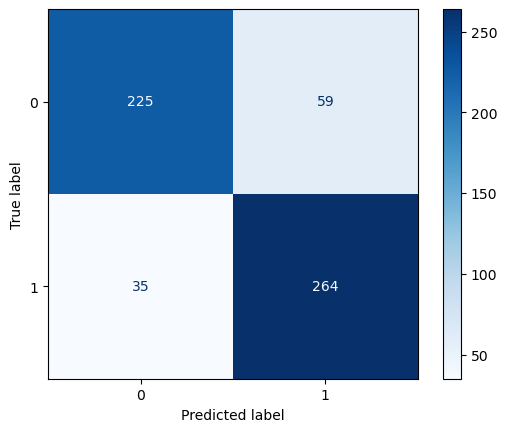

In [38]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues', values_format='d');

In [39]:
#newframe['text'] = [x if '\n' in x else 0 for x in newframe['text']]

In [40]:
#let's do a good old logistic regression!
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [41]:
gslog = GridSearchCV(pipe2, pipe_params, cv = 5)

In [42]:
gslog.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [100, 500, 1000, 2000, 3000],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english', None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [43]:
gslog.score(X_train,y_train)

0.9864750633981403

In [44]:
gslog.best_estimator_

Pipeline(steps=[('cvec', CountVectorizer(max_features=2000)),
                ('lr', LogisticRegression())])

In [45]:
gslog.best_score_

0.8909711792891368

In [46]:
gslog.score(X_test,y_test)

0.8576329331046312

Model 2(cvec lr)

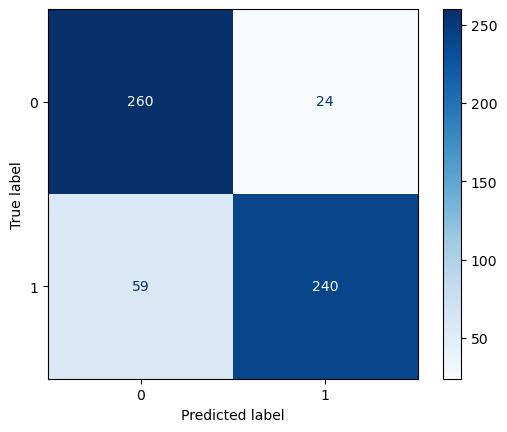

In [47]:
ConfusionMatrixDisplay.from_estimator(gslog, X_test, y_test, cmap='Blues', values_format='d');
# logistic regression wins again!

new X_Train y_train with features

## Doing one more multinomial bayes with stemming for the requirement ##

In [48]:
#cvec with stemming


In [49]:
stemmer = PorterStemmer()

In [50]:
 # got this function to pass the tokeizer from here https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/ and vijay
def tokenize(text):
    tokens = word_tokenize(text)
    stems = [stemmer.stem(token) for token in tokens]
    return stems

In [51]:
tokenize(X_train[1007]); #checking function

In [52]:
X_train.head()

1007    \n\nYes, I think children should be featured i...
448     What’s being straight got to do with it?\n\nEv...
1238    \n\nThe Democratic nominee for president is ex...
1454       \n\nNo, yellow jackets do not remember people.
1246    \n\nIt is impossible to answer this question a...
Name: text, dtype: object

In [53]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer(tokenizer=tokenize)),
    ('mnb', MultinomialNB())
])

In [54]:
pipe_paramsstem = {
'cvec__max_features' : [100,500, 1000, 2000],
'cvec__ngram_range' : [(1,1), (1,2)],
}

In [55]:
gsstem = GridSearchCV(pipe3, pipe_paramsstem, cv = 5)

In [56]:
gsstem.fit(X_train,y_train)

c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ellio\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ellio\anaconda3\Lib\site-packages\sk

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000002AA4CC7BBA0>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_features': [100, 500, 1000, 2000],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [57]:
gsstem.score(X_train,y_train), gsstem.score(X_test,y_test)

(0.8951817413355875, 0.8765008576329331)

In [58]:
gsstem.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=1000, ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x000002AA4CC7BBA0>)),
                ('mnb', MultinomialNB())])

In [59]:
gsstem.best_score_

0.8740756633054424

Model 3(cvec, mnb, stemming)

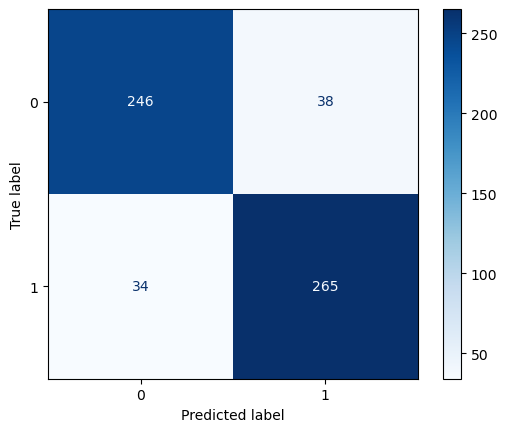

In [60]:
ConfusionMatrixDisplay.from_estimator(gsstem, X_test, y_test, cmap='Blues', values_format='d');